**Importing Libraries**

In [1]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 8.3 MB/s eta 0:00:00


In [22]:
import numpy as np
import cv2 as cv
import os
import tifffile as tif
import segmentation_models as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from segmentation_models import get_preprocessing
from sklearn.model_selection import train_test_split

In [6]:
!unzip training_groundtruth.zip

Archive:  training_groundtruth.zip
  inflating: training_groundtruth.tif  


In [7]:
images = tif.imread("/content/training(1).tif")
masks = tif.imread("/content/training_groundtruth.tif")

**Preprocessing**

In [8]:
images = np.array(images)
masks = np.array(masks)

In [12]:
x = []
for i in range(len(images)):
  x.append(images[i][0:256,256:512])

In [13]:
y = []
for i in range(len(masks)):
  y.append(masks[i][0:256,256:512])

In [14]:
x_up = []
for i in range(len(x)):
  x_up.append(cv.merge((x[i],x[i],x[i])))

In [15]:
x_up = np.array(x_up)

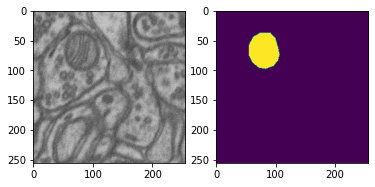

In [18]:
plt.subplot(1,2,1)
plt.imshow(x_up[10])
plt.subplot(1,2,2)
plt.imshow(y[10])

In [19]:
x_up.shape

(165, 256, 256, 3)

In [20]:
np.unique(y)

array([  0, 255], dtype=uint8)

In [24]:
y = np.array(y)

**Encoding the Pixels**

In [26]:
labelencoder = LabelEncoder()
n,h,w = y.shape
y_reshaped = y.reshape(-1,1)
y_encoded = labelencoder.fit_transform(y_reshaped)
y_original = y_encoded.reshape(n,h,w)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
y_original.shape

(165, 256, 256)

In [28]:
y_re = y_original.reshape(165,256,256,1)

In [29]:
y_re.shape

(165, 256, 256, 1)

In [30]:
X = x_up/255
Y = y_re/255

**Model Building**

In [32]:
backbone = "resnet34"
preprocess = get_preprocessing(backbone)
model = sm.Unet(backbone_name=backbone,classes=1,activation="sigmoid")

85521592/85521592 [==============================] - 2s 0us/step


In [33]:
X = preprocess(X)
Y = preprocess(Y)

In [34]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',sm.metrics.iou_score])

In [35]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

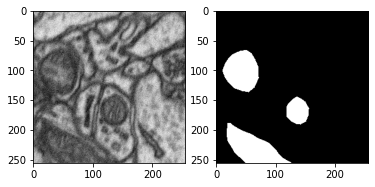

In [50]:
plt.subplot(1,2,1)
plt.imshow(x_train[30,:,:,0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y_train[30,:,:,0],cmap='gray')

In [ ]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=500,batch_size=5)    #i stopped the epochs before 500 

In [45]:
y_pred = model.predict(x_test)

2/2 [==============================] - 4s 674ms/step


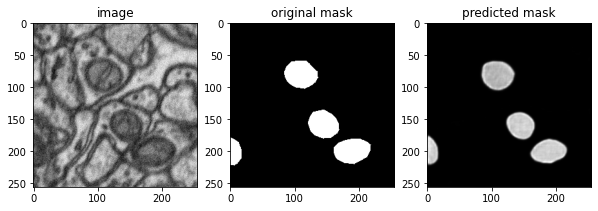

In [54]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("image")
plt.imshow(x_test[22,:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.title("original mask")
plt.imshow(y_test[22,:,:,0],cmap='gray')
plt.subplot(1,3,3)
plt.title("predicted mask")
plt.imshow(y_pred[22,:,:,0],cmap='gray')

In [56]:
from keras.metrics import MeanIoU
y_thresh = y_pred>0.5
iou = MeanIoU(num_classes=2)
iou.update_state(y_test,y_thresh)
print("print iou score " , iou.result().numpy())

print iou score  1.0
